In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
df = pd.read_csv('../../data/maildata_cleaned.csv')
df.head()


,Category,Message,text_length,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah dont think goes usf lives around though


In [3]:
print(df.columns)
print(df.head())

Index(['Category', 'Message', 'text_length', 'clean_text'], dtype='object')
  Category                                            Message  text_length  \
0      ham  Go until jurong point, crazy.. Available only ...          111   
1      ham                      Ok lar... Joking wif u oni...           29   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...          155   
3      ham  U dun say so early hor... U c already then say...           49   
4      ham  Nah I don't think he goes to usf, he lives aro...           61   

                                          clean_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4        nah dont think goes usf lives around though  


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['Category'], test_size=0.2, random_state=42)

In [5]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ('nb', MultinomialNB(alpha=0.1))  
])

In [6]:
df = df.dropna(subset=['clean_text', 'Category'])


In [7]:
df = df.dropna(subset=['clean_text', 'Category'])
df = df[df['clean_text'].str.strip() != '']

X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['Category'], test_size=0.2, random_state=42)

model.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('nb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [8]:
y_pred = model.predict(X_test)


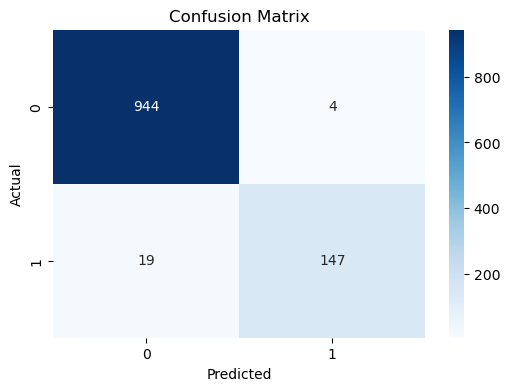

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       948
        spam       0.97      0.89      0.93       166

    accuracy                           0.98      1114
   macro avg       0.98      0.94      0.96      1114
weighted avg       0.98      0.98      0.98      1114

Accuracy: 0.9794


In [11]:
import joblib

joblib.dump(model, 'naive_bayes_model.pkl')

['naive_bayes_model.pkl']